<a href="https://colab.research.google.com/github/sfsernao/Bootcamp_BSU_MIT/blob/main/Propagation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propagation Microring Resonator

Authors:

1. Rafael Angel Casalins Hernández (rcasalins@unal.edu.co)
2. Pedro Ignacio Torres Trujillo

## Python Libraries

In [ ]:
# # Install ibraries for 2D waveguide mode calculations
# !pip install femwell
# !pip install scikit-fem[all]
# !apt-get install libglu1-mesa

In [ ]:
# # Install librarias for FTDT propagation
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install pymeep pymeep-extras

In [ ]:
# Import libraries for 2D waveguide mode calculations
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import shapely
import shapely.affinity
from scipy.constants import epsilon_0, speed_of_light
from shapely.ops import clip_by_rect
from skfem import Basis, ElementTriP0
from skfem.io.meshio import from_meshio

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.visualization import plot_domains

In [ ]:
# Import libraries for FDTD propagation
import meep as mp
import meep.materials as materials
from meep import Animate2D
import numpy as np
from matplotlib import pyplot as plt

## A little introdution

The main objective of this project is to developt an optical fiber sensor with a hight sensibility. We proposed an optical fiber with a D-shape:

![Benjamin Bannekat](https://lh3.googleusercontent.com/u/0/drive-viewer/AKGpihZ7cIp45gX1JCtg3YV2_mRwNKVSMe2uXNgSVo4qNHn2iRsoEwBOAaQ42i7VPRs4Q2pUTKOFcogYp6Q-asXyiKdEczwledqWXnM=w1920-h382-v0)

and on the fiber there is a waveguide with microrings resonators. The fiber and the waveguide are coupling through the evanecent field, in such way that the resonance in the microrings affect the spectrum of the fiber and, at the same time, the refractive index (1.33-1.336) around the microrings affect their behavior.

## Materials

The first thing that we gonna do is to add the materials of all the components using the Meep predefine materials and the Sellmier equation:

In [ ]:
# Silicon DIoxide
SiO2 = materials.fused_quartz

# Silicon
Si  = materials.Si

In [ ]:
# Silicon dioxide doped with 4.1% of GeO2
def SiO2_doped(w):
  A1 = 0.6867178
  A2 = 0.4348151
  A3 = 0.8965658
  L1 = 0.0726752
  L2 = 0.1151435
  L3 = 10.002398

  n = np.sqrt( 1 + ((A1*(w**2))/((w**2)-(L1**2))) + ((A2*(w**2))/((w**2)-(L2**2))) + ((A3*(w**2))/((w**2)-(L3**2))) )

  return n

## Waveguide mode calculation

First we calculate $n_{eff}$ and the modes of the straigh waveguide, in this case we select a square cross profile with $440 nm$ in each side. The material for the waveguide will be silicon, because its refractive index is aprox. 3.4, therefore the wavelenght inside the waveguide will be aprox. $440 \, nm$, enough to confine the light.

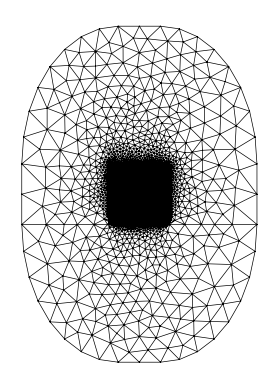

In [ ]:
# waveguide width
wg_width = 0.44

# waveguide thickness
wg_thickness = 0.44

# core shape
core = shapely.geometry.box(-wg_width / 2, 0, +wg_width / 2, wg_thickness)

# enviroment shape
env = shapely.affinity.scale(core.buffer(1, resolution=8), xfact=0.7)

# geometries creation
polygons = OrderedDict(
    core=core,
    box=clip_by_rect(env, -np.inf, -np.inf, np.inf, 0),
    clad=clip_by_rect(env, -np.inf, 0, np.inf, np.inf),
)

# resolution
resolutions = dict(core={"resolution": 0.01, "distance": 0.5})

# mesh
mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=10))
mesh.draw().show()

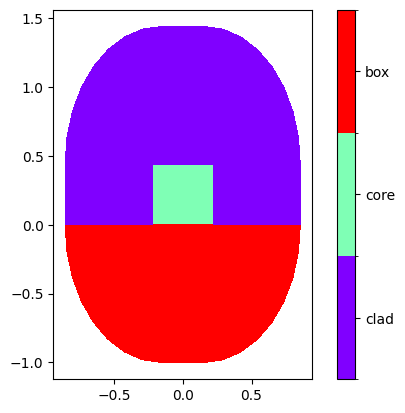

In [ ]:
plot_domains(mesh)
plt.show()

In [ ]:
type(np.sqrt(Si.epsilon(1/1.55))[0,0])

numpy.float64

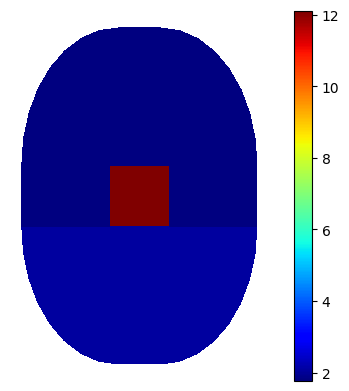

In [ ]:
# refractive index assign: core: Si, clad: 1.33 (water), box (fiber clad): SiO2

basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()

for subdomain, n in {"core": np.sqrt(Si.epsilon(1/1.55))[0,0], "box": np.sqrt(SiO2.epsilon(1/1.55))[0,0], "clad": 1.33}.items():
    epsilon[basis0.get_dofs(elements=subdomain)] = n**2
basis0.plot(epsilon, colorbar=True).show()

Effective refractive index: 2.7608+0.0000j


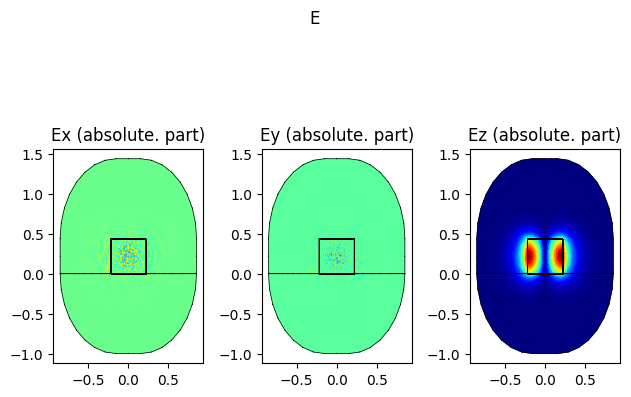

Effective refractive index: 2.7651+0.0000j


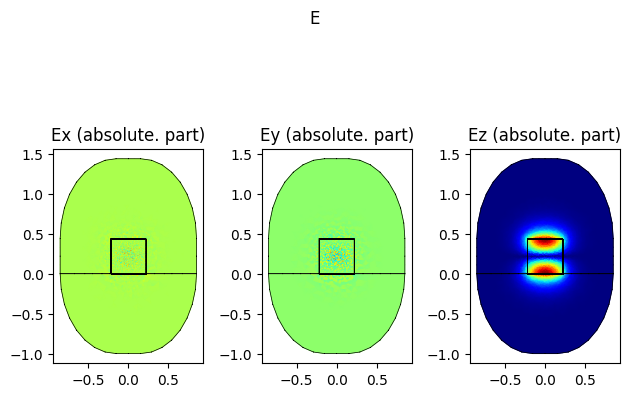

Effective refractive index: 2.0016+0.0000j


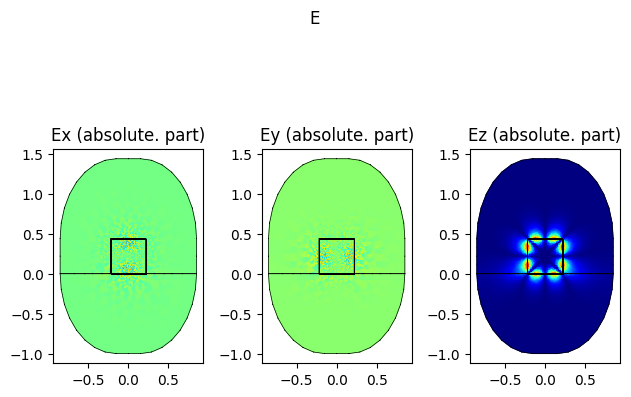

Effective refractive index: 1.6103+0.0000j


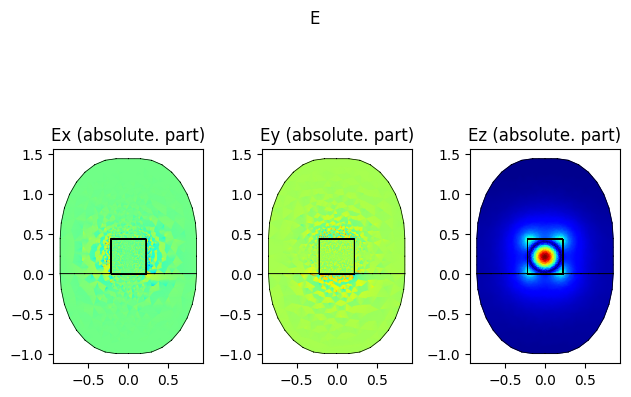

Effective refractive index: 1.4766+0.0000j


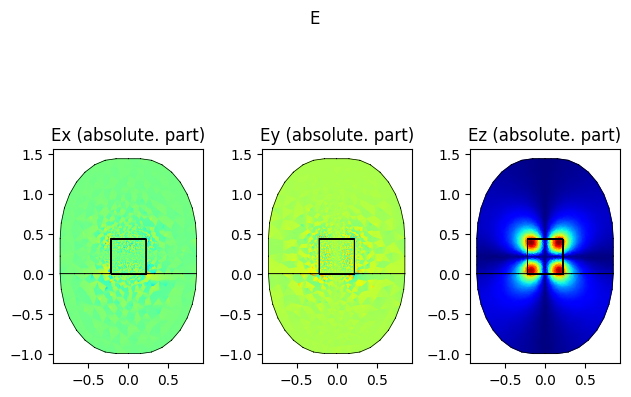

In [ ]:
# Mode calculation for a wavelenght of 1.55 um
wavelength = 1.55

# The first 5 modes
modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=5, order=2)
for mode in modes:
    print(f"Effective refractive index: {mode.n_eff:.4f}")
    #mode.show("E", part="real", colorbar=True)
    #mode.show("E", part="imag", colorbar=True)
    mode.show("E", part="abs")

In [ ]:
# we take the n_eff of the fundamental TE mode
n_eff_TE0 = modes[0].n_eff.real
print('Effective refractive index fundamental TE mode:', n_eff_TE0)

Effective refractive index fundamental TE mode: 2.7608203649334144


## Spectrum response straigh waveguide

### Simulation settings

In [ ]:
# Create the geometry of the waveguide
waveguide = mp.Block(center=mp.Vector3(0, 0, 0.22), size=mp.Vector3(mp.inf, 0.44, 0.44), material= mp.Medium(index = np.sqrt(Si.epsilon(1/1.55))[0,0]))

clad      = mp.Block(center=mp.Vector3(0, 0, -1), size=mp.Vector3(mp.inf, mp.inf, 2), material= mp.Medium(index = np.sqrt(SiO2.epsilon(1/1.55))[0,0]))

# list of waveguides
geometries = [waveguide, clad]

In [ ]:
# Create a gaussian source

# center frequency
fcen = 1/1.55

# width frequency, wavelenght 1.438-1.68 um
df   = 0.05

# source
src  = mp.Source(mp.GaussianSource(fcen, fwidth=df), mp.Ez, mp.Vector3(-7,0,.22),size=mp.Vector3(0,0.42,0.42))

# list of sources
srcs = [src]

In [ ]:
# Boundary conditions: PML
pml_layers = [mp.PML(1.0)]

In [ ]:
# Simulation cell: 21 um X 23 um X 3 um
cell = mp.Vector3(21, 23, 3)

In [ ]:
# Simulación
# based in the previously defined objects and with 1.33 refractive index around the waveguide
sim = mp.Simulation(cell_size = cell,
                   boundary_layers = pml_layers,
                   geometry = geometries,
                    sources = srcs,
                   resolution = 10,
                   default_material=mp.Medium(index=1.33))

### Geometry visualization

In [ ]:
# simulate a steady state
sim.run(until=1)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000975132 s
Working in 3D dimensions.
Computational cell is 21 x 23 x 3 with resolution 10
     block, center = (0,0,0.22)
          size (1e+20,0.44,0.44)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     block, center = (0,0,-1)
          size (1e+20,1e+20,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0852,2.0852,2.0852)
time for set_epsilon = 7.01931 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1.0)

Meep progress: 0.05/1.0 = 5.0% done in 6.5s, 122.7s to go
on time step 1 (time=0.05), 6.44671 s/step
run 0 finished at t = 1.0 (20 timesteps)


In [ ]:
# verified the the geometry

# get the permittivity in all the simulation cell
eps_data = sim.get_epsilon()

# epsilon in cross profile in log scale
eps_cross = np.rot90(np.log(eps_data[100,:,:]))


# epsilon in propagation axis
eps_propation = eps_data[:,:,17]

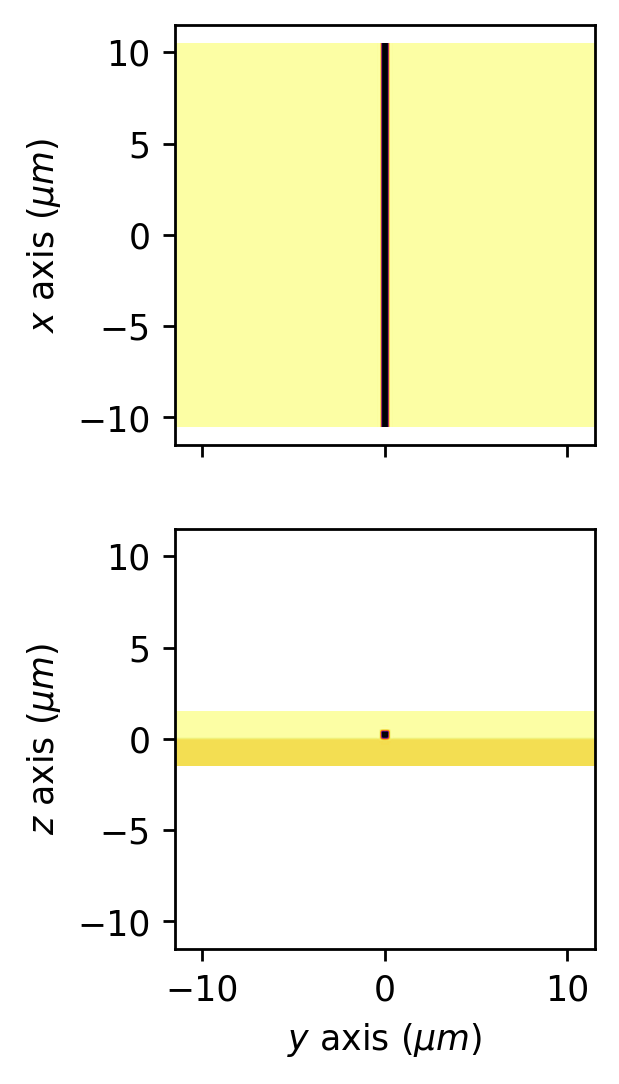

In [ ]:
import matplotlib.colors as colors
from matplotlib import cm

levels = np.array([1.33, np.sqrt(SiO2.epsilon(1/1.55))[0,0]], np.sqrt(Si.epsilon(1/1.55))[0,0])
cmap = cm.PRGn

fig2, (ax, ax2) = plt.subplots(nrows=2, sharex=True, dpi = 250)
epsilon_propagation = ax.imshow((eps_propation), interpolation="spline36", cmap="inferno_r", extent =[-23/2,23/2,-21/2,21/2])
epsilon_cross       = ax2.imshow((eps_cross), interpolation="spline36", cmap="inferno_r", extent = [-23/2,23/2,-3/2,3/2])

ax.set_box_aspect(1)
ax2.set_box_aspect(1)

ax2.set_ylim(-1,1)

ax2.set_xlabel(r'$y$ axis ($\mu m$)')
ax2.set_ylabel(r'$z$ axis ($\mu m$)')

ax.set_ylabel(r'$x$ axis ($\mu m$)')

plt.show()

In [ ]:
# reset the simulation
sim.reset_meep()

### Steady state

In [ ]:
# we simulate a steady state
sim.run(until=150)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00100303 s
Working in 3D dimensions.
Computational cell is 21 x 23 x 3 with resolution 10
     block, center = (0,0,0.22)
          size (1e+20,0.44,0.44)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     block, center = (0,0,-1)
          size (1e+20,1e+20,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0852,2.0852,2.0852)
time for set_epsilon = 6.84335 s
-----------


FloatProgress(value=0.0, description='0% done ', max=150.0)

Meep progress: 0.05/150.0 = 0.0% done in 7.2s, 21610.9s to go
on time step 1 (time=0.05), 7.19989 s/step
Meep progress: 2.75/150.0 = 1.8% done in 11.2s, 601.7s to go
on time step 55 (time=2.75), 0.0745693 s/step
Meep progress: 5.65/150.0 = 3.8% done in 15.3s, 390.8s to go
on time step 113 (time=5.65), 0.0699417 s/step
Meep progress: 8.3/150.0 = 5.5% done in 19.3s, 329.8s to go
on time step 166 (time=8.3), 0.0759665 s/step
Meep progress: 10.950000000000001/150.0 = 7.3% done in 23.3s, 296.3s to go
on time step 219 (time=10.95), 0.0756172 s/step
Meep progress: 13.850000000000001/150.0 = 9.2% done in 27.4s, 269.2s to go
on time step 277 (time=13.85), 0.0696935 s/step
Meep progress: 16.6/150.0 = 11.1% done in 31.4s, 252.4s to go
on time step 332 (time=16.6), 0.0732018 s/step
Meep progress: 19.200000000000003/150.0 = 12.8% done in 35.4s, 241.3s to go
on time step 384 (time=19.2), 0.0770317 s/step
Meep progress: 22.05/150.0 = 14.7% done in 39.5s, 228.9s to go
on time step 441 (time=22.05), 0.

In [ ]:
# get the field on each direction
ez_data = np.real(sim.get_efield_z())
ex_data = np.real(sim.get_efield_x())
ey_data = np.real(sim.get_efield_y())

# calculare E^2
E2 = (ez_data**2) + (ex_data**2) + (ey_data**2)

# get the field in the progation direction at z = 0.2 um
E2_propagation = E2[:,:,17]

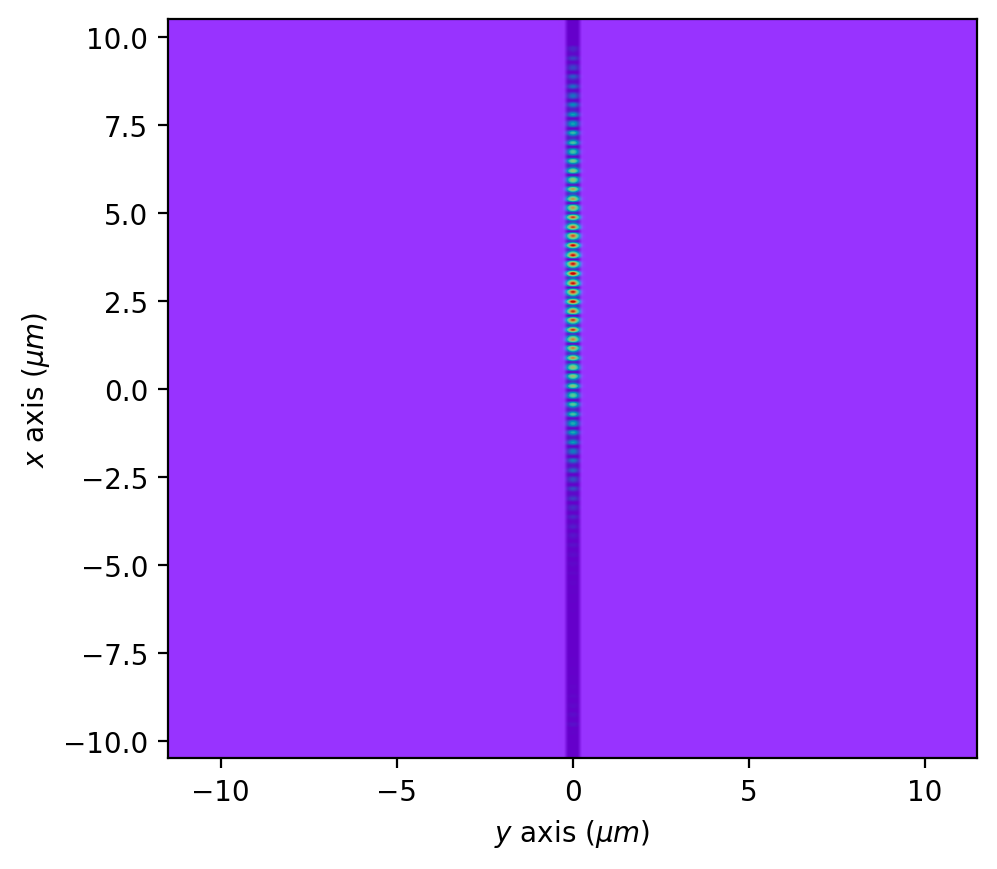

In [ ]:
fig, ax = plt.subplots(dpi = 200)
epsilon = ax.imshow(eps_propation, interpolation="spline36", cmap="gray_r", extent =[-23/2,23/2,-21/2,21/2])
field = ax.imshow(
    np.flipud((E2_propagation)),
    interpolation="spline36",
    cmap="rainbow",
    alpha=0.8,
    extent =[-23/2,23/2,-21/2,21/2]
)
ax.set_ylabel(r'$x$ axis ($\mu m$)')
ax.set_xlabel(r'$y$ axis ($\mu m$)')

plt.show()

### Spectrum

In [ ]:
# reset simulation
sim.reset_meep()

In [ ]:
# Spectrum monitor
nfreq = 200  # number of frequencies at which to compute flux

# Size and center of the monitor: a square 0.45 um X 0.45 um at the end of the
Flux_without_ring_fr = mp.FluxRegion(
    center=mp.Vector3(9,0,.22), size=mp.Vector3(0,0.45,0.45))

Flux_without_ring = sim.add_flux(fcen, df, nfreq, Flux_without_ring_fr)

flux_freqs = mp.get_flux_freqs(Flux_without_ring)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00106502 s
Working in 3D dimensions.
Computational cell is 21 x 23 x 3 with resolution 10
     block, center = (0,0,0.22)
          size (1e+20,0.44,0.44)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     block, center = (0,0,-1)
          size (1e+20,1e+20,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0852,2.0852,2.0852)
time for set_epsilon = 7.07891 s
-----------


In [ ]:
# simulate until the pulse has passed through the waveguide
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, np.sqrt((mp.Ex**2)+(mp.Ey**2)+(mp.Ez**2)), mp.Vector3(9,0,.22), 1e-3))

on time step 1 (time=0.05), 6.55108 s/step
on time step 51 (time=2.55), 0.0801523 s/step
on time step 108 (time=5.4), 0.0706385 s/step
on time step 166 (time=8.3), 0.0696559 s/step
on time step 216 (time=10.8), 0.0809444 s/step
on time step 273 (time=13.65), 0.0705354 s/step
on time step 331 (time=16.55), 0.0696353 s/step
on time step 381 (time=19.05), 0.080897 s/step
on time step 439 (time=21.95), 0.069779 s/step
on time step 497 (time=24.85), 0.069977 s/step
on time step 547 (time=27.35), 0.0802015 s/step
on time step 605 (time=30.25), 0.0694586 s/step
on time step 663 (time=33.15), 0.0697349 s/step
on time step 712 (time=35.6), 0.0817806 s/step
on time step 769 (time=38.45), 0.070579 s/step
on time step 827 (time=41.35), 0.0697717 s/step
on time step 876 (time=43.8), 0.0818388 s/step
on time step 933 (time=46.65), 0.0709255 s/step
on time step 991 (time=49.55), 0.0701166 s/step
field decay(t = 50.050000000000004): 2.049572095695937e-16 / 2.049572095695937e-16 = 1.0
on time step 1042

In [ ]:
# get the flux
FluxWithout = mp.get_fluxes(Flux_without_ring)

# convert flux to array
FluxWithout = np.array(FluxWithout)

# create wavelenght array
wl = []

for i in range(nfreq):
    wl = np.append(wl, 1 / flux_freqs[i])

As we expected, the spectrum response has a gaussian distribution, due to the gaussian sourcce:

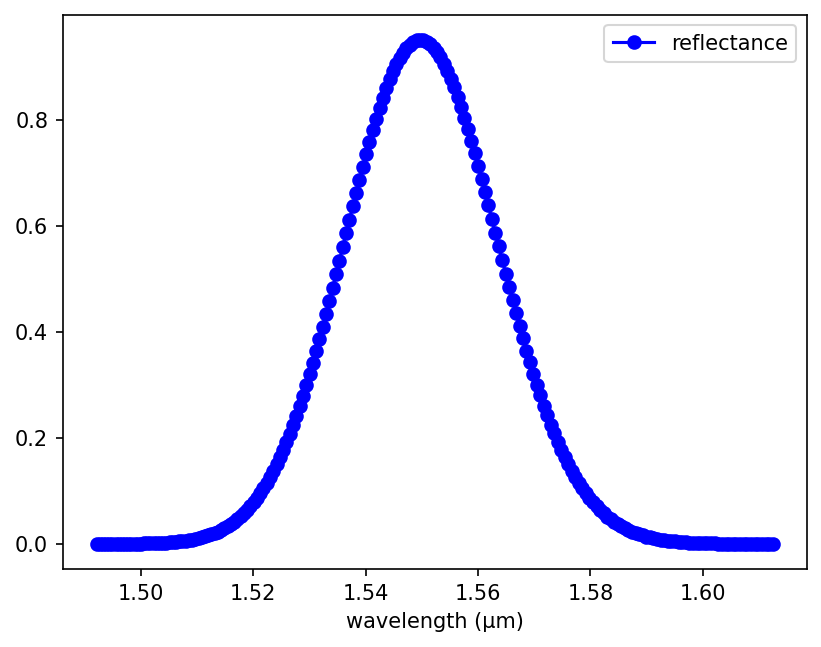

In [ ]:
if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, FluxWithout, "bo-", label="reflectance")
    #plt.axis([1.5, 1.6, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

## Spectrum response straigh waveguide with microrings resonator

The phase matching condition for a microring resonator is:

$$ m \lambda = 2 \pi R n_{eff}$$

Therefore:

$$ R = \frac{m \lambda}{2 \pi n_{eff}} $$

First, we define the wavelengh resonance range:

$$ \lambda = [1.52,1.58] $$

In [ ]:
wavelenght_resonance = np.array([1.5,1.6])

Then, we calculate the radius of resonance for this wavelenght, using the $n_{eff}$ of the fundamental TE mode:

In [ ]:
radius = (40* wavelenght_resonance) / (2*np.pi * n_eff_TE0)
r_thick = radius[1]-radius[0]
print('Int. radius: ', radius[0], 'Ext. radius: ', radius[1], 'Thickness: ', r_thick)

Int. radius:  3.458861976970396 Ext. radius:  3.689452775435089 Thickness:  0.23059079846469333


$$ R = [3.505,3.643] \; \mu m $$

In [ ]:
# create structure
waveguide = mp.Block(center=mp.Vector3(0, 0, 0.22), size=mp.Vector3(mp.inf, 0.44, 0.44), material= mp.Medium(index = np.sqrt(Si.epsilon(1/1.55))[0,0]))

microring_out_1 = mp.Cylinder(radius= radius[1], center=mp.Vector3(0, r_thick+radius[1], 0.22) , height=0.44, material= mp.Medium(index = np.sqrt(Si.epsilon(1/1.55))[0,0]))
microring_in_1 = mp.Cylinder(radius= radius[0], center=mp.Vector3(0, r_thick+radius[1], 0.22) , height=0.44, material = mp.Medium(index = 1.33))

microring_out_2 = mp.Cylinder(radius= radius[1], center=mp.Vector3(1.72*radius[1], r_thick+2*radius[1], 0.22) , height=0.44, material= mp.Medium(index = np.sqrt(Si.epsilon(1/1.55))[0,0]))
microring_in_2 = mp.Cylinder(radius= radius[0], center=mp.Vector3(1.72*radius[1], r_thick+2*radius[1], 0.22) , height=0.44, material = mp.Medium(index = 1.33))

microring_out_3 = mp.Cylinder(radius= radius[1], center=mp.Vector3(-1.72*radius[1], r_thick+2*radius[1], 0.22) , height=0.44, material= mp.Medium(index = np.sqrt(Si.epsilon(1/1.55))[0,0]))
microring_in_3 = mp.Cylinder(radius= radius[0], center=mp.Vector3(-1.72*radius[1], r_thick+2*radius[1], 0.22) , height=0.44, material = mp.Medium(index = 1.33))

clad      = mp.Block(center=mp.Vector3(0, 0, -1), size=mp.Vector3(mp.inf, mp.inf, 2), material= mp.Medium(index = np.sqrt(SiO2.epsilon(1/1.55))[0,0]))

In [ ]:
geometries = [waveguide, clad, microring_out_1, microring_in_1, microring_out_2, microring_in_2, microring_out_3, microring_in_3]

In [ ]:
# Gaussian source

# center frequency
fcen = 1/1.55

# width frequency, wavelenght 1.438-1.68 um
df   = 0.05

src  = mp.Source(mp.GaussianSource(fcen, fwidth=df), mp.Ez, mp.Vector3(-7,0,.22),size=mp.Vector3(0,0.42,0.42))

In [ ]:
# PML
pml_layers = [mp.PML(1.0)]

In [ ]:
# Simulación
# based in the previously defined objects
sim2 = mp.Simulation(cell_size = mp.Vector3(21, 23, 3),
                   boundary_layers = pml_layers,
                   geometry = geometries,
                    sources = [src],
                   resolution = 10,
                   default_material=mp.Medium(index=1.33))

### Geometry visualization

In [ ]:
sim2.run(until = 1)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00115895 s
Working in 3D dimensions.
Computational cell is 21 x 23 x 3 with resolution 10
     block, center = (0,0,0.22)
          size (1e+20,0.44,0.44)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     block, center = (0,0,-1)
          size (1e+20,1e+20,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0852,2.0852,2.0852)
     cylinder, center = (0,3.92004,0.22)
          radius 3.68945, height 0.44, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     cylinder, center = (0,3.92004,0.22)
          radius 3.45886, height 0.44, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1.7689,1.7689,1.7689)
     cylinder, center = (6.34586,7.6095,0.22)
          radius 3.68945, height 0.44, axis (0, 0, 1)
          dielectric constant epsilon diagonal

FloatProgress(value=0.0, description='0% done ', max=1.0)

Meep progress: 0.05/1.0 = 5.0% done in 7.6s, 144.3s to go
on time step 1 (time=0.05), 7.581 s/step
run 0 finished at t = 1.0 (20 timesteps)


In [ ]:
# verified the the geometry

# get the permittivity in all the simulation cell
eps_data = sim2.get_epsilon()

# epsilon in cross profile in log scale
eps_cross = np.rot90(np.log(eps_data[100,:,:]))


# epsilon in propagation axis
eps_propation = eps_data[:,:,17]

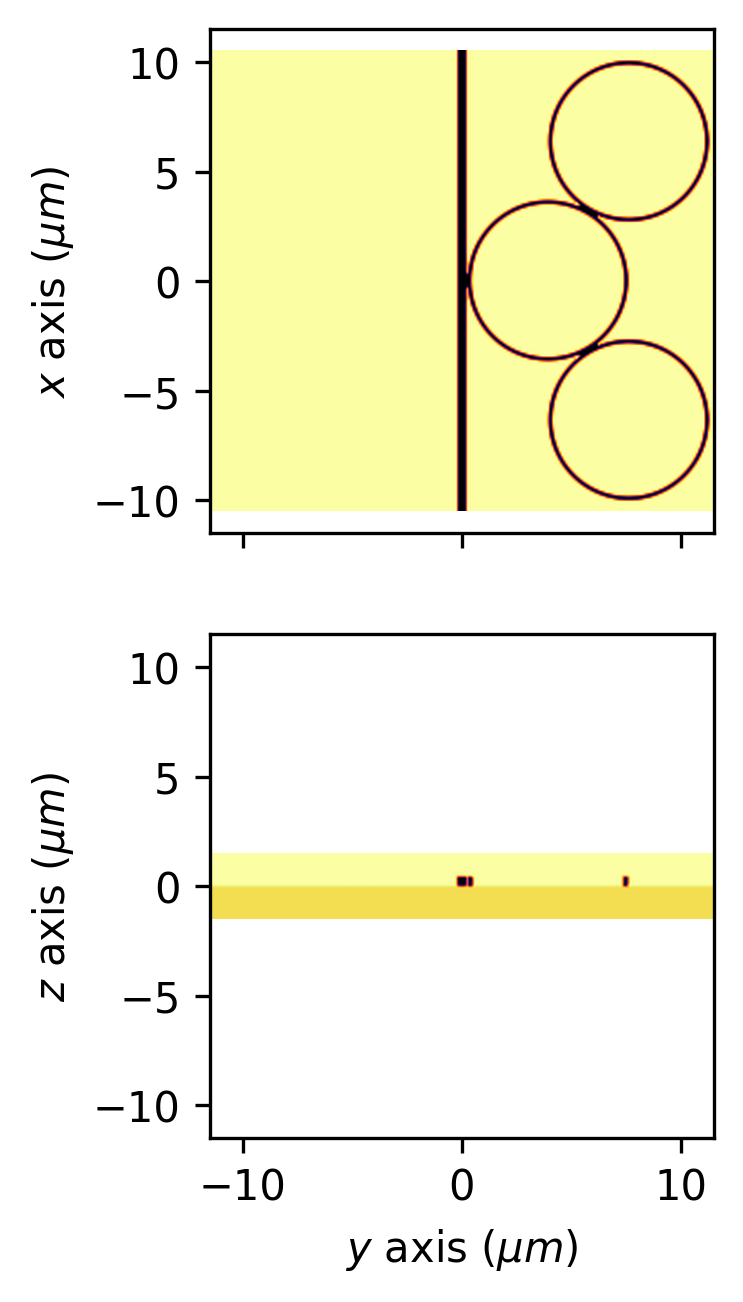

In [ ]:
fig2, (ax, ax2) = plt.subplots(nrows=2, sharex=True, dpi = 300)
epsilon_propagation = ax.imshow((eps_propation), interpolation="spline36", cmap="inferno_r", extent =[-23/2,23/2,-21/2,21/2])
epsilon_cross       = ax2.imshow((eps_cross), interpolation="spline36", cmap="inferno_r", extent = [-23/2,23/2,-3/2,3/2])

ax.set_box_aspect(1)
ax2.set_box_aspect(1)

ax2.set_xlabel(r'$y$ axis ($\mu m$)')
ax2.set_ylabel(r'$z$ axis ($\mu m$)')

ax.set_ylabel(r'$x$ axis ($\mu m$)')

plt.show()

In [ ]:
# reset the simulation
sim2.reset_meep()

### Steady state

In [ ]:
sim2.run(until=150)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00117183 s
Working in 3D dimensions.
Computational cell is 21 x 23 x 3 with resolution 10
     block, center = (0,0,0.22)
          size (1e+20,0.44,0.44)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     block, center = (0,0,-1)
          size (1e+20,1e+20,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0852,2.0852,2.0852)
     cylinder, center = (0,3.92004,0.22)
          radius 3.68945, height 0.44, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     cylinder, center = (0,3.92004,0.22)
          radius 3.45886, height 0.44, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1.7689,1.7689,1.7689)
     cylinder, center = (6.34586,7.6095,0.22)
          radius 3.68945, height 0.44, axis (0, 0, 1)
          dielectric constant epsilon diagonal

FloatProgress(value=0.0, description='0% done ', max=150.0)

Meep progress: 0.05/150.0 = 0.0% done in 6.3s, 18984.4s to go
on time step 1 (time=0.05), 6.32411 s/step
Meep progress: 2.35/150.0 = 1.6% done in 10.3s, 650.2s to go
on time step 47 (time=2.35), 0.0872897 s/step
Meep progress: 5.050000000000001/150.0 = 3.4% done in 14.4s, 413.8s to go
on time step 101 (time=5.05), 0.0752657 s/step
Meep progress: 7.7/150.0 = 5.1% done in 18.5s, 341.1s to go
on time step 154 (time=7.7), 0.0761569 s/step
Meep progress: 10.0/150.0 = 6.7% done in 22.5s, 314.9s to go
on time step 200 (time=10), 0.0876623 s/step
Meep progress: 12.700000000000001/150.0 = 8.5% done in 26.6s, 287.1s to go
on time step 254 (time=12.7), 0.0750838 s/step
Meep progress: 15.450000000000001/150.0 = 10.3% done in 30.6s, 266.7s to go
on time step 309 (time=15.45), 0.0739954 s/step
Meep progress: 17.8/150.0 = 11.9% done in 34.7s, 257.6s to go
on time step 356 (time=17.8), 0.0861435 s/step
Meep progress: 20.55/150.0 = 13.7% done in 38.8s, 244.1s to go
on time step 411 (time=20.55), 0.0740

In [ ]:
# get the field on each direction
ez_data = np.real(sim2.get_efield_z())
ex_data = np.real(sim2.get_efield_x())
ey_data = np.real(sim2.get_efield_y())

# calculare E^2
E2 = (ez_data**2) + (ex_data**2) + (ey_data**2)

# get the field in the progation direction at z = 0.2 um
E2_propagation = E2[:,:,17]

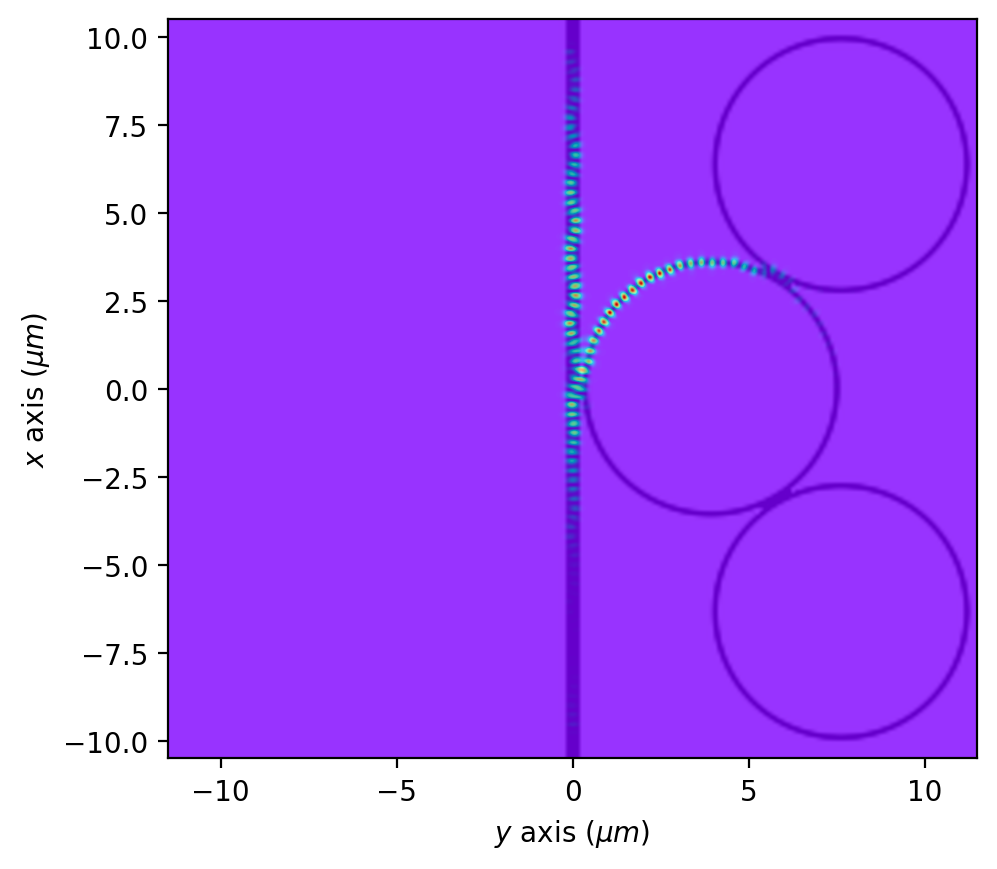

In [ ]:
fig, ax = plt.subplots(dpi = 200)
epsilon = ax.imshow(eps_propation, interpolation="spline36", cmap="gray_r", extent =[-23/2,23/2,-21/2,21/2])
field = ax.imshow(
    np.flipud((E2_propagation)),
    interpolation="spline36",
    cmap="rainbow",
    alpha=0.8,
    extent =[-23/2,23/2,-21/2,21/2]
)
ax.set_ylabel(r'$x$ axis ($\mu m$)')
ax.set_xlabel(r'$y$ axis ($\mu m$)')

plt.show()

In [ ]:
sim2.reset_meep()

### Spectrum

In [ ]:
# Spectrum monitor
nfreq = 200  # number of frequencies at which to compute flux

# Size and center of the monitor: a square 0.45 um X 0.45 um at the end of the
Flux_with_ring_fr = mp.FluxRegion(
    center=mp.Vector3(9,0,.22), size=mp.Vector3(0,0.45,0.45))

Flux_with_ring = sim2.add_flux(fcen, df, nfreq, Flux_with_ring_fr)

flux_freqs = mp.get_flux_freqs(Flux_without_ring)

In [ ]:
# simulate until the pulse has passed through the waveguide
sim2.run(until_after_sources=mp.stop_when_fields_decayed(50, np.sqrt((mp.Ex**2)+(mp.Ey**2)+(mp.Ez**2)), mp.Vector3(9,0,.22), 1e-3))

-----------
Initializing structure...
time for choose_chunkdivision = 0.00127602 s
Working in 3D dimensions.
Computational cell is 21 x 23 x 3 with resolution 10
     block, center = (0,0,0.22)
          size (1e+20,0.44,0.44)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     block, center = (0,0,-1)
          size (1e+20,1e+20,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0852,2.0852,2.0852)
     cylinder, center = (0,3.92004,0.22)
          radius 3.68945, height 0.44, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     cylinder, center = (0,3.92004,0.22)
          radius 3.45886, height 0.44, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1.7689,1.7689,1.7689)
     cylinder, center = (6.34586,7.6095,0.22)
          radius 3.68945, height 0.44, axis (0, 0, 1)
          dielectric constant epsilon diagonal

In [ ]:
# get the flux
FluxWith = mp.get_fluxes(Flux_with_ring)

# convert flux to array
FluxWith = np.array(FluxWith)

# create wavelenght array
wl = []

for i in range(nfreq):
    wl = np.append(wl, 1 / flux_freqs[i])

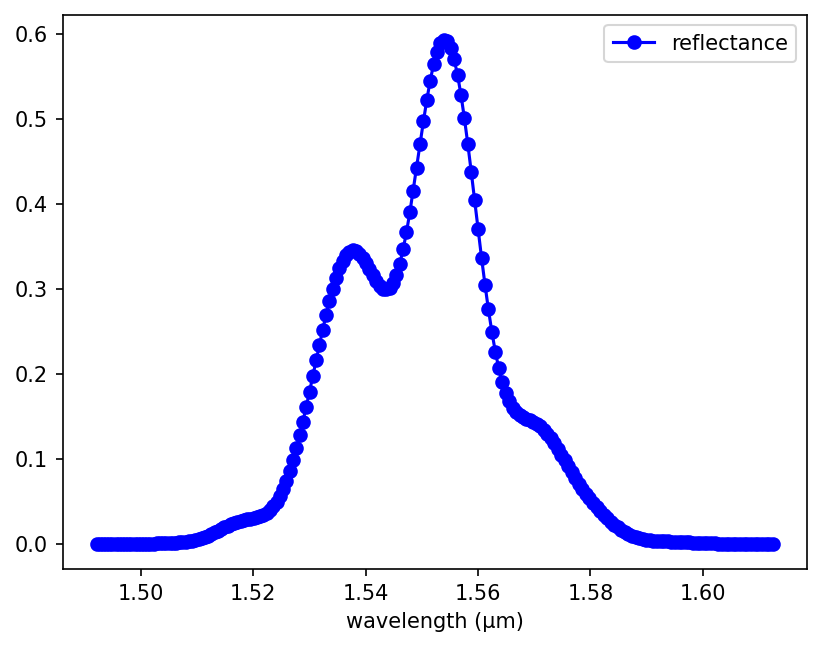

In [ ]:
plt.figure(dpi=150)
plt.plot(wl, FluxWith, "bo-", label="reflectance")
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
plt.show()

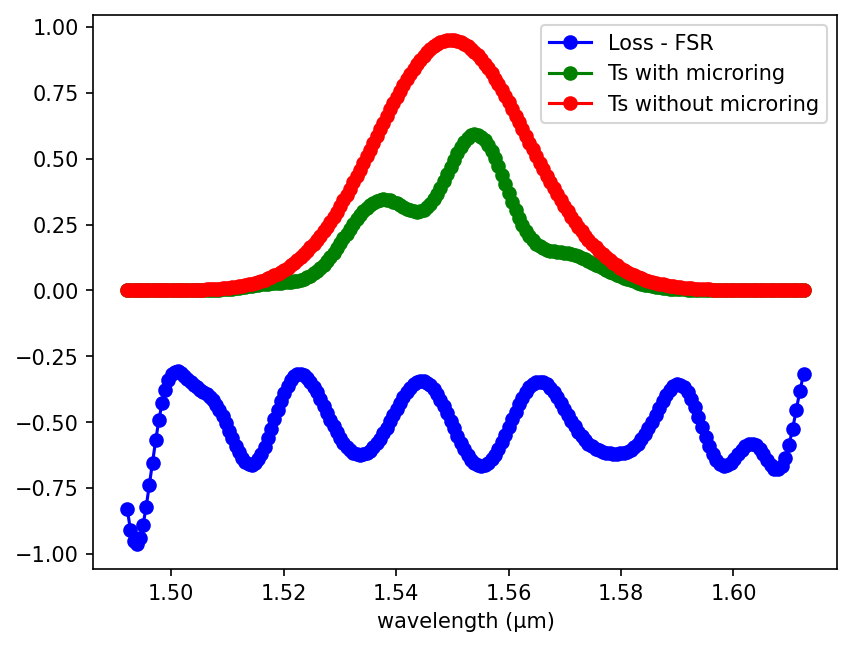

In [ ]:
FSR = -FluxWith / FluxWithout

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, FSR, "bo-", label="Loss - FSR")
    plt.plot(wl, FluxWith, "go-", label="Ts with microring")
    plt.plot(wl, FluxWithout, "ro-", label="Ts without microring")
    #plt.axis([1.5, 1.6, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()